# url: https://www.salesanalytics.co.jp/datascience/datascience066/

# 顧客別CLTV（顧客生涯価値）モデルをPython Lifetimes でサクッと作る方法を事例で学ぶ

顧客別CLTV（Individual CLTV）とは、顧客の金銭的価値のことで、将来行う取引に基づいて算出されます。

個々の顧客が将来どのくらいの利益を生み出すかがわかれば、価値の高い顧客に対し、マーケティング活動などを集中できます。

顧客別CLTV（Individual CLTV）が分かれば、例えば以下の2つの分析につなげることが多いです。

    離反阻止分析（チャーン分析）
    出世魚分析（隠れた宝石探し）

価値の高い顧客は、離反阻止すべきですし、取引額拡大に向けて活動すべきです。

要は、短期的な収益ではなく、長期的な収益に視点を当てた活動ができるということです。

では、実際にどのようなデータで、どのようなモデルを構築すれば、CLTV（顧客生涯価値）を求めることができるのか？

今回は、「顧客別CLTV（顧客生涯価値）モデルを Python Lifetimes でサクッと作る方法を事例で学ぶ」というお話しです。

# リード（見込み顧客）のCLTV（顧客生涯価値）

CLTV（顧客生涯価値）は、取引履歴のある既存顧客に対して見積もります。

取引履歴のないリード（見込み顧客）や1回しか取引していない顧客のCLTV（顧客生涯価値）を見積もるときには、既存顧客のCLTV（顧客生涯価値）を見積もった後に、マッチングの技術などを使い見積もります。

何はともあれ、取引履歴のある既存顧客に対しCLTV（顧客生涯価値）を見積もるところから始まります。

ちなみに、マッチングの方法は色々ありますが、一番簡単なのは、顧客の属性情報などをもとに類似度（もしくは非類似度）を計算し、重み付け平均などで見積もる方法です。このあたりの話題は、別の機会にお話しします。(以下を参考にする。)

url: https://www.salesanalytics.co.jp/datascience/datascience185/

# 取引履歴のある既存顧客のCLTV（顧客生涯価値）

既存顧客のCLTV（顧客生涯価値）は、過去の取引状況などをもとに考えていきます。

例えば……

    購買確率
    離反確率
    購買金額
    購買回数
    購買間隔

……などを過去の取引状況などをもとに計算し、CLTV（顧客生涯価値）を計算します。

お互いに関係しあっていますので、すべてを計算する必要はありません。例えば、購買回数が0であれば、離反確率は100%です。

今回紹介するCLTV（顧客生涯価値）予測モデルは、以下の2つです。

    購買回数モデル（BG/NBDモデル）
    購買金額モデル（GGモデル）

BG/NBDモデル（Beta Geometric/Negative Binomial Distribution）で回数を予測し、金額／回をGGモデル（Gamma-Gamma model）で予測します。

CLTV（顧客生涯価値）モデルは、この2つのモデルを融合したものです。

CLTV = 回数×金額／回で計算できます。

Pyhtonですと、以下のLifetimesパッケージです。

url: https://pypi.org/project/Lifetimes/

# Lifetimesのインストール

コマンドプロンプト上で、pipでインストールするときのコードは以下です。

In [1]:
pip install lifetimes

# サンプルデータ

CLTV（顧客生涯価値）をモデル化するには、トランザクションデータが必要です。

ECサイトのトランザクションデータである購買データ（OnlineRetail.csv）を使います。UCI Machine Learning Repositoryで提供されているOnline Retail Data Setのデータセットです。

必要な方は、以下からダウンロードしてください。

Acquire Valued Shoppers Challenge

url: https://archive.ics.uci.edu/ml/datasets/Online+Retail

url: 弊社サイトからダウンロードする場合は以下から

https://www.salesanalytics.co.jp/jwga

# 必要なパッケージの読み込み

以下、コードです。

In [2]:
# パッケージ読み込み
import numpy as np
import pandas as pd
#　import pandas_profiling #  ydata-profilingとinstall and importする必要があるが、google colabではサポートされていないため現時点では使用不可
from statistics import mean
from sklearn.metrics import mean_absolute_error
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
import matplotlib.pyplot as plt
# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

# データセットのプロファイリング用のパッケージ（Pandas-Profiling）以外は、特別なパッケージは利用していません。
# Pandas-Profilingのインストールは、以下を参考にしてください。絶対に必要なものでもないので、
# 無視してしてしまっても問題ありません。

# url: https://www.salesanalytics.co.jp/datascience/datascience014/

# データセット読み込み
データセットを読み込みます。ECサイトの取引履歴です。

以下、コードです。

In [3]:
# データセット読み込み
url = 'https://www.salesanalytics.co.jp/jwga'
df = pd.read_csv(url)

# pd.read_csv('/content/OnlineRetail.csv') # csvで読み込む場合

# データセットの確認
display(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010/12/1 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010/12/1 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010/12/1 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010/12/1 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010/12/1 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011/12/9 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011/12/9 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011/12/9 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011/12/9 12:50,4.15,12680.0,France


In [4]:
# andas-Profilingで、読み込んだデータセットをプロファイリングします。
# 以下、コードです。

# データセットのプロファイリング
# pandas_profiling.ProfileReport(df, minimal=True)

# 以下、実行結果です。画像をクリックすると別タブで実行結果を見れます。

# 実行結果ではないが、describeで代用
df.describe(include = 'all')

# Quantity（購入数）とUnitPrice（単価）のMinimumを見ると、マイナスの数値になっています。
# 返品などでマイナスの数値になっている取引があることが分かります。

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011/10/31 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


Lifetimesパッケージの扱うトランザクションデータは、以下の3つの変数で構成されるデータセットを前提としています。

    顧客ID
    取引日（購入日、注文日など）
    取引金額（購入金額、注文金額など）

この3つの変数で構成されるトランザクションデータを元に、RFM（frequency・recency・T・monetary_value）の4つの変数を計算し作成したデータセットを使い、モデル構築などを行います。Lifetimesパッケージ独自の定義です。

    frequency：データセット内の、リピート回数（ = 購買回数 – 1 ）
    recency：データセット内の、アクティブ期間（最初に購入してから最近の購入までの期間）
    T：データセット内で最初に購入してから、そのデータセットが終了するまでの期間
    monetary_value：データセット内のリピート時の平均購入金額

# 前処理
先ず、以下の3つの変数で構成されるLifetimesパッケージ用のトランザクションデータを作ります。

    CustomerID：顧客ID
    InvoiceDate：購入日
    purchaseamount：購入金額

以下、コードです。

In [5]:
# 合計金額を計算
df['purchaseamount'] = df['Quantity'] * df['UnitPrice']

# 返品処理などを削除
df = df.loc[df['purchaseamount'] > 0.0]

# 顧客ID・日時・金額のトランザクションデータを生成
transaction_data = df.groupby(['CustomerID', 'InvoiceDate'])['purchaseamount'].sum().reset_index()

# データセットの確認
display(transaction_data)

,CustomerID,InvoiceDate,purchaseamount
0,12346.0,2011/1/18 10:01,77183.60
1,12347.0,2010/12/7 14:57,711.79
2,12347.0,2011/1/26 14:30,475.39
3,12347.0,2011/10/31 12:25,1294.32
4,12347.0,2011/12/7 15:52,224.82
...,...,...,...
18435,18283.0,2011/7/14 13:20,2.50
18436,18283.0,2011/9/5 12:35,134.90
18437,18287.0,2011/10/12 10:23,1001.32
18438,18287.0,2011/10/28 9:29,70.68


この3つの変数で構成されるトランザクションデータを元に、RFM（frequency・recency・T・monetary_value）の4つの変数を計算し、モデル構築用のデータセットを作ります。

以下、コードです。

In [6]:
# 提供されたコードは、RFM（Recency, Frequency, Monetary）分析のためのデータセットを生成し、その内容を確認するための処理です。
# RFM分析は、顧客の購買行動を理解し、セグメント化するための手法です。

# RFMデータセット生成:summary_data_from_transaction_data 関数を使用して、購買トランザクションデータからRFMデータセットを生成しています。
rfm = summary_data_from_transaction_data(
    transaction_data,
    'CustomerID',
    'InvoiceDate',
    observation_period_end='2011-11-30',
    monetary_value_col = 'purchaseamount'
)

# transaction_data: 購買トランザクションのデータセットです。
# 'CustomerID': 顧客IDの列名です。これに基づいて顧客ごとに集計が行われます。
# 'InvoiceDate': 購買トランザクションの発生日時の列名です。これを使用してRecency（最終購入日からの経過日数）を計算します。
# observation_period_end='2011-11-30': データセットの観察期間の終了日を指定しています。これはRFM分析の対象期間を設定するもので、この期間内のデータが対象とされます。
# monetary_value_col='purchaseamount': Monetary（購買金額）の計算に使用される金額の列名です。

# データセットの確認
# display 関数を使用して、生成されたRFMデータセットを表示しています。
display(rfm)

# この部分では、RFMデータセットが表示され、各顧客に対してRecency、Frequency、Monetaryの各列が計算されていることが確認できます。
# RFMデータセットは、顧客ごとに購買行動を要約したデータであり、これを基に顧客をセグメント化してマーケティング戦略を立案するなどの活用が可能です。



# frequency：データセット内の、リピート回数（ = 購買回数 – 1 ）
# recency：データセット内の、アクティブ期間（最初に購入してから最近の購入までの期間）
# T：データセット内で最初に購入してから、そのデータセットが終了するまでの期間
# monetary_value：データセット内のリピート時の平均購入金額

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,316.0,0.000000
12347.0,5.0,328.0,358.0,674.678000
12348.0,3.0,283.0,349.0,301.480000
12349.0,0.0,0.0,9.0,0.000000
12350.0,0.0,0.0,301.0,0.000000
...,...,...,...,...
18280.0,0.0,0.0,268.0,0.000000
18281.0,0.0,0.0,171.0,0.000000
18282.0,0.0,0.0,117.0,0.000000


In [7]:
# リピート回数（frequency）が1以上のデータに絞ります。
# 以下、コードです。

# frequencyが1以上のデータに絞る
rfm = rfm.loc[rfm['frequency'] > 0]

# データセットの確認
display(rfm)

# ただ、このデータセットを使いモデル構築し検証するわけではありません。
# 通常の機械学習モデルと同様に、学習データとテストデータに分け、学習データでモデル構築し、構築したモデルをテストデータで検証します。

# トランザクションデータのような、時系列なデータは、期間で学習データとテストデータを分割します。
# 分割する時期を決め学習データ期間とテストデータ期間に分けます。

# 今回は、約1年間のデータであるため、前半半年（学習データ期間）と後半半年（テストデータ期間）に分けます。

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,5.0,328.0,358.0,674.678000
12348.0,3.0,283.0,349.0,301.480000
12352.0,6.0,260.0,287.0,365.718333
12356.0,2.0,303.0,316.0,269.905000
12359.0,3.0,274.0,322.0,1941.693333
...,...,...,...,...
18270.0,1.0,228.0,257.0,111.950000
18272.0,4.0,201.0,237.0,526.612500
18273.0,1.0,162.0,248.0,102.000000


# データ期間分割（学習データ期間とテストデータ期間）

では、先程作成した3つの変数（CustomerID・InvoiceDate・purchaseamount）で構成されたトランザクションデータを、前半半年（学習データ期間）と後半半年（テストデータ期間）に分割します。

以下、コードです。



In [8]:
# 提供されたコードは、RFM（Recency, Frequency, Monetary）分析において、データを学習用とテスト用に分割する処理を行っています。
# これは、モデルのトレーニングと評価を異なる期間で行うことで、モデルの予測性能を評価するための手法です。

# データ期間分割（学習データ期間とテストデータ期間）:calibration_and_holdout_data 関数を使用して、学習データとテストデータにデータを分割しています。
rfm_train_test = calibration_and_holdout_data(
    transaction_data,
    'CustomerID',
    'InvoiceDate',
    calibration_period_end='2011-5-31',
    observation_period_end='2011-11-30',
    monetary_value_col = 'purchaseamount'
)

# transaction_data: 購買トランザクションのデータセットです。
# 'CustomerID': 顧客IDの列名です。これに基づいて顧客ごとに集計が行われます。
# 'InvoiceDate': 購買トランザクションの発生日時の列名です。これを使用してRecency（最終購入日からの経過日数）を計算します。
# calibration_period_end='2011-5-31': 学習データの期間終了日を指定しています。これが学習期間となります。
# observation_period_end='2011-11-30': テストデータの期間終了日を指定しています。これがテスト期間となります。
# monetary_value_col='purchaseamount': Monetary（購買金額）の計算に使用される金額の列名です。

# データセットの確認
# display 関数を使用して、生成された学習用とテスト用のRFMデータセットを表示しています。
display(rfm_train_test)
# この段階で rfm_train_test には、学習データおよびテストデータがそれぞれの期間に基づいて作成されたRFMデータが格納されています。

# これを使用して、学習期間内の顧客行動からモデルをトレーニングし、テスト期間内の顧客行動を予測して性能を評価することができます。

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346.0,0.0,0.0,133.0,0.00,0.0,0.000000,183.0
12347.0,2.0,121.0,175.0,555.82,3.0,753.916667,183.0
12348.0,2.0,110.0,166.0,297.22,1.0,310.000000,183.0
12350.0,0.0,0.0,118.0,0.00,0.0,0.000000,183.0
12352.0,3.0,34.0,104.0,421.77,3.0,314.743333,183.0
...,...,...,...,...,...,...,...
18272.0,1.0,21.0,54.0,340.72,3.0,576.720000,183.0
18273.0,0.0,0.0,65.0,0.00,1.0,102.000000,183.0
18280.0,0.0,0.0,85.0,0.00,0.0,0.000000,183.0


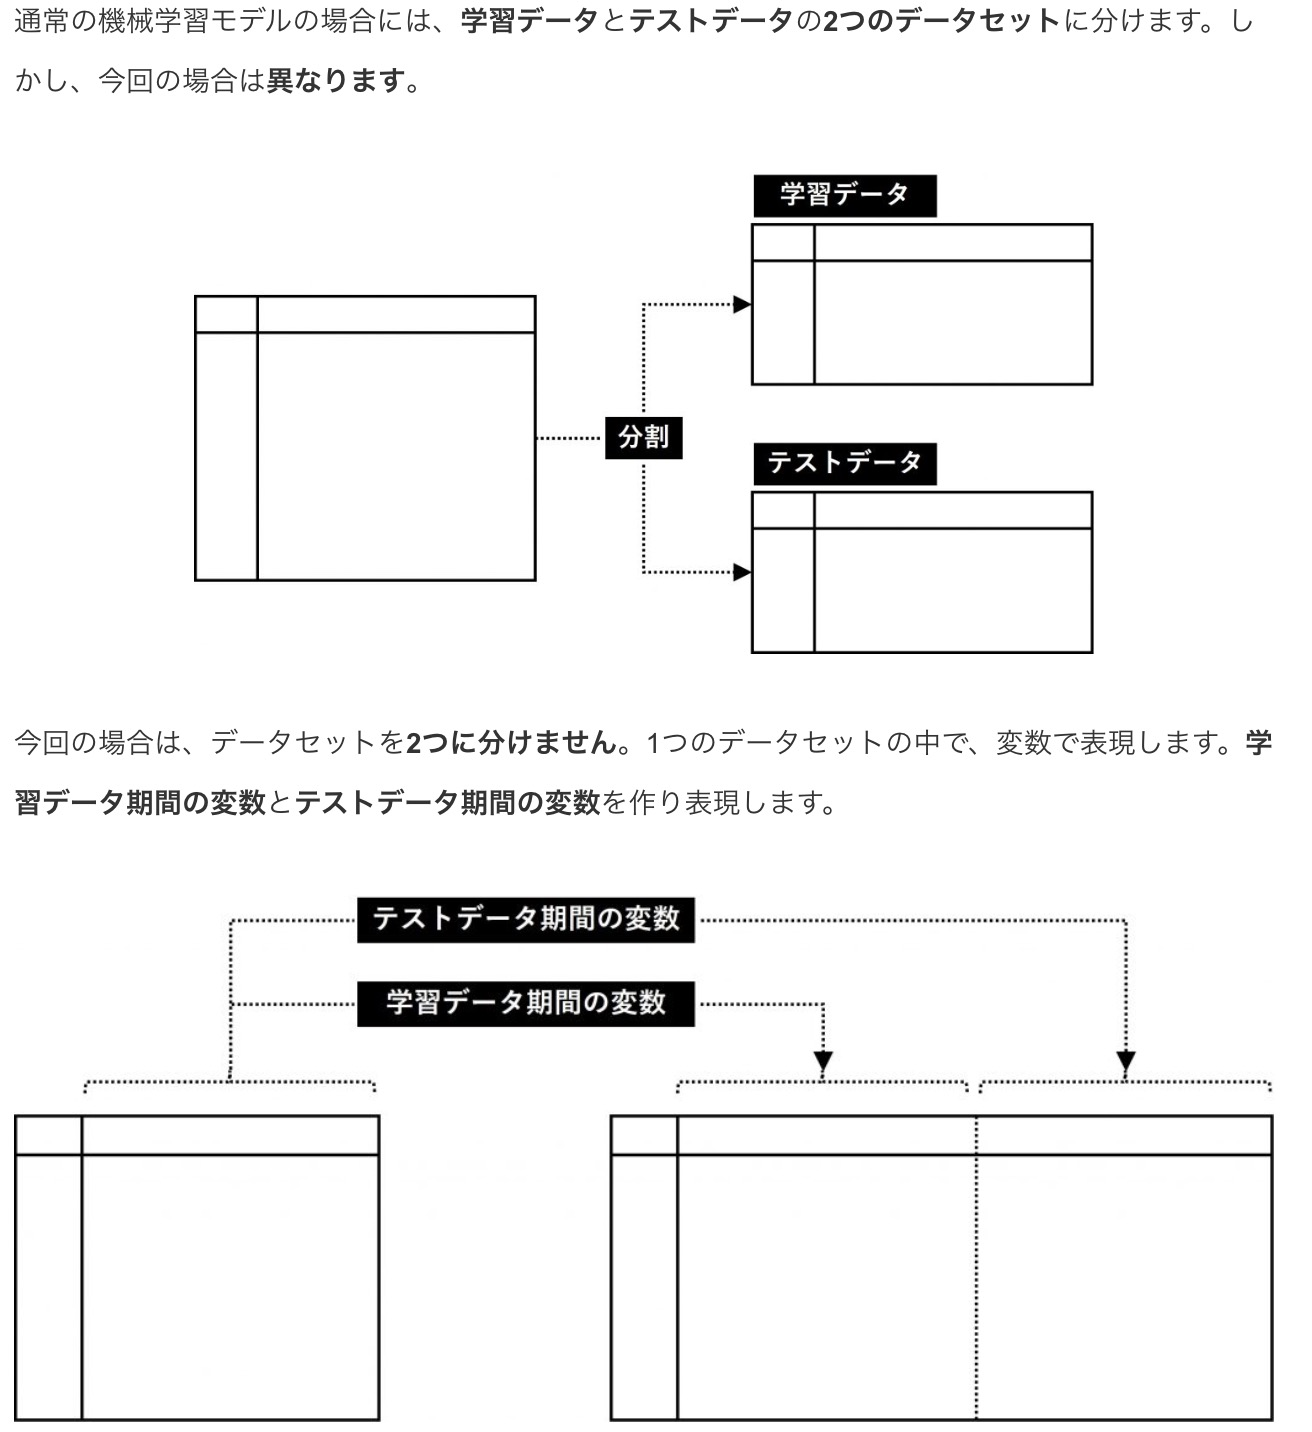

In [9]:
# リピートした既存顧客に絞るために、リピート回数（frequency）が1以上のデータに絞ります。
# 以下、コードです。

# 学習データ期間のfrequency（frequency_cal）が1以上のデータに絞る
rfm_train_test = rfm_train_test.loc[rfm_train_test.frequency_cal > 0, :]

# データセットの確認
display(rfm_train_test)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12347.0,2.0,121.0,175.0,555.8200,3.0,753.916667,183.0
12348.0,2.0,110.0,166.0,297.2200,1.0,310.000000,183.0
12352.0,3.0,34.0,104.0,421.7700,3.0,314.743333,183.0
12356.0,1.0,80.0,133.0,481.4600,1.0,58.350000,183.0
12359.0,1.0,26.0,139.0,1838.9100,2.0,1993.085000,183.0
...,...,...,...,...,...,...,...
18245.0,2.0,144.0,163.0,470.2800,1.0,183.260000,183.0
18257.0,2.0,90.0,104.0,196.4000,4.0,323.286000,183.0
18260.0,4.0,153.0,166.0,496.3425,1.0,427.130000,183.0


# 購買回数モデル（BG/NBDモデル）

BG/NBDモデル（Beta Geometric/Negative Binomial Distribution）で購買回数を予測します。

このモデルは、Faderら(2005)のモデルが元になっています。
Fader, Peter S., Bruce GS Hardie, and Ka Lok Lee. ““Counting your customers” the easy way: An alternative to the Pareto/NBD model.” Marketing science 24.2 (2005): 275-284.

url: http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf

この論文の基本的な考え方というアプローチは、顧客の購買確率と離反確率をもとにモデルを考えています。具体的には、購買のガンマ分布と離反のベータ分布です。

では、学習データ期間（前半半年）のデータ（変数）を使ってモデルを構築します。

以下、コードです。


In [10]:
# 提供されたコードは、BG/NBD（Beta Geometric/Negative Binomial Distribution）モデルを学習するための処理です。
# BG/NBDモデルは、リピート購買が期待される顧客の購買行動をモデリングするのに使用されます。
# これは顧客の継続的な購買行動を考慮しているため、リピート購買の確率やリピート購買までの時間などを予測するのに適しています。

# BG/NBDモデルの学習（学習データ期間）
# BG/NBDモデルのインスタンス化:BetaGeoFitter クラスのインスタンスを作成して、BG/NBDモデルを構築します。
bgf = BetaGeoFitter(penalizer_coef=0)
# penalizer_coef: 正則化項の係数で、デフォルトでは0に設定されています。正則化は、モデルが過剰に適合しないようにするために使用されます。

# BG/NBDモデルのトレーニング:
bgf.fit(
    rfm_train_test['frequency_cal'],
    rfm_train_test['recency_cal'],
    rfm_train_test['T_cal']
)

# rfm_train_test['frequency_cal']: 顧客の購買頻度（Frequency）の学習データ。
# rfm_train_test['recency_cal']: 顧客の最終購買からの経過日数（Recency）の学習データ。
# rfm_train_test['T_cal']: 顧客が観察される期間の長さ（トレーニングデータ期間）。

# これにより、BG/NBDモデルは学習データに基づいてパラメータを推定し、その後の予測に使用する準備が整います。
# 学習データ期間内での顧客の購買行動をもとに、顧客の将来の購買活動を予測できるようになります。

<lifetimes.BetaGeoFitter: fitted with 1327 subjects, a: 0.00, alpha: 126.79, b: 0.03, r: 2.96>

In [11]:
# 提供されたコードは、BG/NBD（Beta Geometric/Negative Binomial Distribution）モデルを使用して、未来の予測を行う処理です。
# 具体的には、半年間の予測期間に対して顧客の購買活動を予測しています。

# 構築したモデルを使って、テストデータ期間（後半半年）の予測をします。
# 以下、コードです。

# 予測期間（半年）
duration_holdout = 183
# duration_holdout: 予測期間の日数を指定しています。この例では半年（183日）を指定しています。

# 予測（予測データ期間）
predicted_bgf = bgf.predict(
    duration_holdout,
    rfm_train_test['frequency_cal'],
    rfm_train_test['recency_cal'],
    rfm_train_test['T_cal']
)

# bgf.predict(): BG/NBDモデルに基づいて未来の予測を行います。
# duration_holdout: 予測期間を指定します。この期間内での購買活動を予測します。
# rfm_train_test['frequency_cal']: 学習データ期間内での顧客の購買頻度（Frequency）のデータ。
# rfm_train_test['recency_cal']: 学習データ期間内での顧客の最終購買からの経過日数（Recency）のデータ。
# rfm_train_test['T_cal']: 顧客が観察される期間の長さ（トレーニングデータ期間）のデータ。
# このコードを実行することで、predicted_bgfには未来半年間における顧客の購買活動の予測が得られます。

# この予測を基に、マーケティング戦略やリテンション戦略を検討することができます。

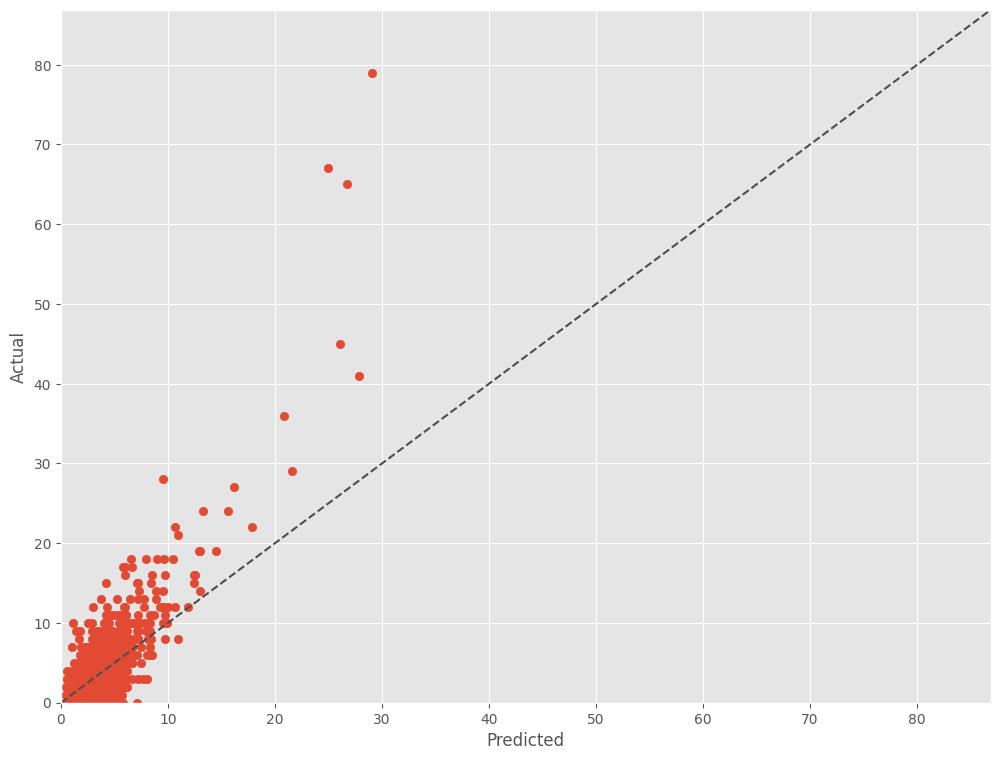

RMSE:
3.4132471222233796
MAE:
2.0489421664425618
R:
0.8263545703189242


In [12]:
# 提供されたコードは、BG/NBDモデルに基づく予測結果と、実測値を比較し、予測の精度を評価するための処理です。
# 以下に、コードの詳細な説明を示します：

# テストデータ期間（後半半年）の実測値（actual）と予測値（predicted）を比較してみます。
# 以下、コードです。

# 実測値と予測値の代入
actual = rfm_train_test['frequency_holdout']
predicted = predicted_bgf

# rfm_train_test['frequency_holdout']: テストデータ期間（後半半年）の実測値（購買頻度）です。
# predicted_bgf: BG/NBDモデルに基づく半年間の予測値です。

# 散布図（予測Predict×実測Actual）
# 散布図を作成し、予測値と実測値を比較しています。理想的な場合、データポイントは45度の直線上に集まることが期待されます。
xylim = max(max(predicted), max(actual))*1.1
plt.scatter(predicted, actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlim(0, xylim)
plt.ylim(0, xylim)
plt.plot([0, xylim], [0,xylim], ls="--", c=".3")
plt.show()

# 予測精度
print('RMSE:')
print(mean((actual - predicted)**2)**.5)

print('MAE:')
print(mean_absolute_error(actual, predicted))

print('R:')
print(np.corrcoef(actual, predicted)[0,1])

# RMSE（Root Mean Squared Error）: 二乗平均平方根誤差を計算して表示します。誤差の平方を取り、その平均値を計算し、その平方根をとったものです。
# MAE（Mean Absolute Error）: 平均絶対誤差を計算して表示します。誤差の絶対値を取り、その平均値を計算します。
# R: 重相関係数を計算して表示します。実測値と予測値の相関の強さを示す指標で、-1から1の範囲の値をとります。

# これらの指標は、予測の精度を評価するために使用されます。RMSEとMAEが小さく、Rが1に近いほど予測が正確です。
# 提供されたコードは、これらの指標を計算してモデルの性能を評価しています。

In [13]:
# 予測値（predicted）に比べ実測値（actual）の方が値が大きい傾向があります。
# そもそも、前半半年（学習データ期間）よりも後半半年（テストデータ期間）の方が、実測値（actual）が大きいのかもしれません。
# 脱線しますが確認してみます。

# 以下、コードです。
rfm_train_test.loc[:,["frequency_cal","frequency_holdout"]].mean()

frequency_cal        2.988696
frequency_holdout    3.782216
dtype: float64

In [14]:
# 前半半年（学習データ期間）よりも後半半年（テストデータ期間）の方が、実測値（actual）が大きいようです。
# この差分は、季節性が影響しているのかもしれません。本来であれば、半年ではなく「学習データ期間：1年間」「テストデータ期間：1年間」とした方がいいでしょう。

# ここで、季節性があるという前提で補正係数を作り、予測値を補正し再度プロットしてみます。
# 先ず、補正係数（frequency_holdout÷frequency_cal）を求めます。
# 以下、コードです。

# 補正係数
freq_cal_mean = rfm_train_test["frequency_cal"].mean()
freq_holdout_mean = rfm_train_test["frequency_holdout"].mean()
correction_coef = freq_holdout_mean / freq_cal_mean
display(correction_coef)

# rfm_train_test["frequency_cal"].mean(): 学習データ期間（calibration）での平均購買頻度を計算しています。
# rfm_train_test["frequency_holdout"].mean(): テストデータ期間（holdout）での平均購買頻度を計算しています。
# correction_coef: 補正係数を計算しています。これは、テストデータ期間での平均購買頻度を学習データ期間での平均購買頻度で割った値です。
# 補正係数は、季節性や他の影響によってテストデータ期間の平均購買頻度が学習データ期間よりも高い（または低い）場合に、予測値を補正するための係数となります。

# この補正係数を用いて、元の予測値を補正して再度プロットすることで、季節性の影響を考慮した予測値を得ることが期待されます。

1.2655068078668683

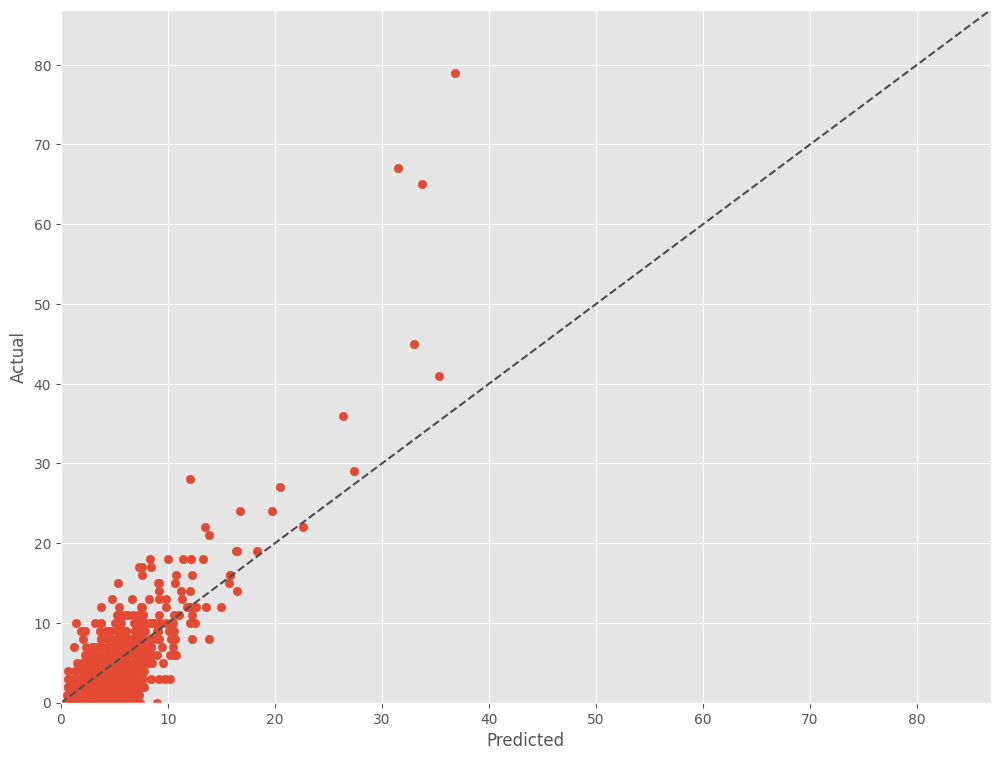

RMSE:
3.258353175930455
MAE:
2.268227611031202
R:
0.826354570318924


In [15]:
# この補正係数を使い予測値を補正しプロットします。
# 以下、コードです。

# 実測値と補正済み予測値の代入
actual = rfm_train_test['frequency_holdout']
predicted = correction_coef * predicted

# 散布図（予測Predict×実測Actual）
xylim = max(max(predicted), max(actual))*1.1
plt.scatter(predicted, actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlim(0, xylim)
plt.ylim(0, xylim)
plt.plot([0, xylim], [0,xylim], ls="--", c=".3")
plt.show()

# 予測精度
print('RMSE:')
print(mean((actual - predicted)**2)**.5)
print('MAE:')
print(mean_absolute_error(actual, predicted))
print('R:')
print(np.corrcoef(actual, predicted)[0,1])

# 購買金額モデル（GGモデル）

金額／回をGGモデル（Gamma-Gamma model）で予測します。このモデルも先程登場したFaderら(2005)のモデルが元になっています。

では、学習データ期間（前半半年）のデータ（変数）を使ってモデルを構築します。

以下、コードです。

In [16]:
# 提供されたコードは、Gamma-Gammaモデル（GGモデル）を学習するための処理です。
# GGモデルは、購買金額（Monetary Value）に対する顧客の忠誠度をモデリングするのに使用されます。
# 具体的には、GGモデルは顧客の購買金額の分布に関するモデルであり、このモデルを用いて顧客ごとの平均購買金額を予測することができます。

# GGモデルの学習（学習期間）
ggf = GammaGammaFitter(penalizer_coef=0)
# GammaGammaFitter: Gamma-Gammaモデルを構築するためのクラスです。
# penalizer_coef=0: 正則化項の係数で、デフォルトでは0に設定されています。正則化は、過剰な適合を防ぐために用いられます。

# GGモデルのトレーニング:
ggf.fit(
    rfm_train_test['frequency_cal'],
    rfm_train_test['monetary_value_cal']
)

# rfm_train_test['frequency_cal']: 学習データ期間内での顧客の購買頻度（Frequency）のデータ。
# rfm_train_test['monetary_value_cal']: 学習データ期間内での顧客の平均購買金額（Monetary Value）のデータ。

# このコードを実行することで、GGモデルは学習データ期間の購買金額に関するパターンを学習し、将来の予測に使用できるようになります。
# GGモデルの学習に成功すると、その後はこれを使用して未来の顧客ごとの平均購買金額を予測することができます。

<lifetimes.GammaGammaFitter: fitted with 1327 subjects, p: 2.98, q: 3.10, v: 300.09>

In [17]:
# 構築したモデルを使って、テストデータ期間（後半半年）の予測をします。
# 以下、コードです。

# 提供されたコードは、構築したGamma-Gammaモデル（GGモデル）を使用して、テストデータ期間の平均購買金額を予測する処理です。
# Gamma-Gammaモデルは購買金額に関するモデルであり、条件付き平均利益を予測することができます。

#予測
predicted_ggf = ggf.conditional_expected_average_profit(
    rfm_train_test['frequency_cal'],
    rfm_train_test['monetary_value_cal']
)

# ggf.conditional_expected_average_profit(): GGモデルを使用して、条件付き平均利益を予測します。
# rfm_train_test['frequency_cal']: 学習データ期間内での顧客の購買頻度（Frequency）のデータ。
# rfm_train_test['monetary_value_cal']: 学習データ期間内での顧客の平均購買金額（Monetary Value）のデータ。

# このコードを実行することで、GGモデルに基づいてテストデータ期間の各顧客に対する条件付き平均利益が予測されます。
# これにより、将来の購買金額の傾向を理解し、マーケティングやリテンション戦略に活かすことができます。

# 予測結果は、predicted_ggfに格納されます。これを利用して、実際の購買金額と比較したり、他のビジネス上の戦略や意思決定に活用できます。



# 条件付き平均利益（Conditional Expected Average Profit）は、Gamma-Gammaモデルなどを用いて予測された平均利益のことです。
# 特に、これは購買金額のモデリングに使われることがあります。

# 以下にそれを具体的に説明します：

# Gamma-Gammaモデルの背景:
# Gamma-Gammaモデルは、購買金額の分布に関するモデルです。このモデルは、一度の購買時の購買金額のバラつきを表現します。

# 条件付き平均利益の概要:
# 条件付き平均利益は、顧客ごとに異なる購買金額の期待値を示します。
# 一般的に、この利益は未来の購買に基づいて計算され、購買頻度と平均購買金額に依存します。

# Gamma-Gammaモデルと条件付き平均利益の関連:
# Gamma-Gammaモデルは、購買金額の分散をモデル化し、その分散から条件付き平均利益を計算します。
# 条件付き平均利益は、個々の顧客に対して異なる分散（購買金額のバラつき）を考慮して計算されるため、顧客ごとの購買行動の特異性を反映します。

# 利用例:
# 条件付き平均利益は、将来の購買金額を予測し、それに基づいて個々の顧客の価値を理解するのに役立ちます。
# マーケティングやリテンション戦略の立案、購買金額に関連した施策の検討などに利用されます。

# 簡単に言えば、Gamma-Gammaモデルから得られる条件付き平均利益は、ある期間内に購買した顧客が将来どれくらいの平均的な利益をもたらすかを予測する指標です。

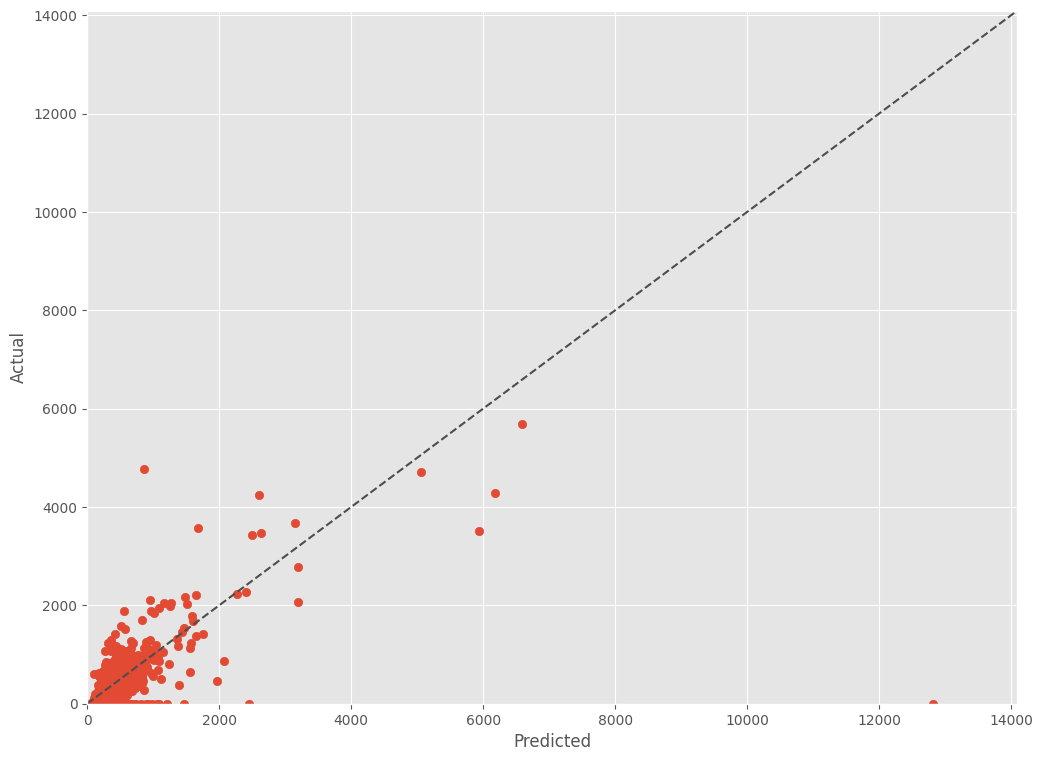

RMSE:
467.0337576989298
MAE:
196.17467850632542
R:
0.5935909637583084


In [18]:
# テストデータ期間（後半半年）の実測値（actual）と予測値（predicted）を比較してみます。
# 以下、コードです。

# 実測値と予測値の代入
actual = rfm_train_test['monetary_value_holdout']
predicted = predicted_ggf

# 散布図（予測Predict×実測Actual）
xylim = max(max(predicted), max(actual))*1.1
plt.scatter(predicted, actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlim(0, xylim)
plt.ylim(0, xylim)
plt.plot([0, xylim], [0,xylim], ls="--", c=".3")
plt.show()

# 予測精度
print('RMSE:')
print(mean((actual - predicted)**2)**.5)
print('MAE:')
print(mean_absolute_error(actual, predicted))
print('R:')
print(np.corrcoef(actual, predicted)[0,1])

# これで、購買回数を予測するBG/NBDモデル（Beta Geometric/Negative Binomial Distribution）と、金額／回を予測するGGモデル（Gamma-Gamma model）ができました。
# 次に、この2つのモデルを融合しCLTV（顧客生涯価値）モデルを構築します

# CLTV（顧客生涯価値）予測

テストデータ期間（後半半年）のCLTV（顧客生涯価値）を予測します。

In [19]:
# 提供されたコードは、Customer Lifetime Value（顧客生涯価値、CLTV）を予測し、それをデータセットに追加する処理です。
# CLTVは、ある顧客が将来的に企業へもたらすであろう価値を予測する指標で、購買履歴やモデルの予測を基に算出されます。

# CLTV予測
cltv = ggf.customer_lifetime_value(
    bgf, # 未来のトランザクション数を予測するために使用するモデル（通常はBG/NBDモデル）
    rfm_train_test['frequency_cal'],
    rfm_train_test['recency_cal'],
    rfm_train_test['T_cal'],
    rfm_train_test['monetary_value_cal'],
    time = 6, # 予測期間を指定（ここでは6ヶ月）
    discount_rate=0.01 # 割引率（デフォルトでは0.01）
)

# ggf.customer_lifetime_value(): Gamma-Gammaモデルを使用して、顧客生涯価値（CLTV）を予測します。
# bgf: 未来のトランザクション数を予測するために使用されるモデル。通常はBG/NBDモデル（購買頻度の予測）が使用されます。
# rfm_train_test['frequency_cal']: 学習データ期間内での顧客の購買頻度（Frequency）のデータ。
# rfm_train_test['recency_cal']: 学習データ期間内での顧客の最終購買からの経過日数（Recency）のデータ。
# rfm_train_test['T_cal']: 顧客が観察される期間の長さ（トレーニングデータ期間）のデータ。
# rfm_train_test['monetary_value_cal']: 学習データ期間内での顧客の平均購買金額（Monetary Value）のデータ。
# time = 6: 予測期間を指定します。ここでは6ヶ月に設定されています。
# discount_rate = 0.01: 割引率を指定します。これは将来のキャッシュフローを現在価値に変換するために使用されます。デフォルトでは0.01（1%）に設定されています。

# データセットにCLTV追加
rfm_train_test['cltv'] = cltv
# 予測されたCLTVをデータセットに新しい列として追加します。

# このコードを実行することで、各顧客の将来の生涯価値が予測され、それがデータセットに新しい列として追加されます。
# これにより、顧客の価値を考慮したマーケティング戦略やリテンション戦略の立案が可能になります。


# timeで予測期間（月）を指定します。月単位です。今回の場合はテストデータ期間が後半半年なのでtime=6としています。
# timeを変更することで、予測する期間の長さを変化させることができます。

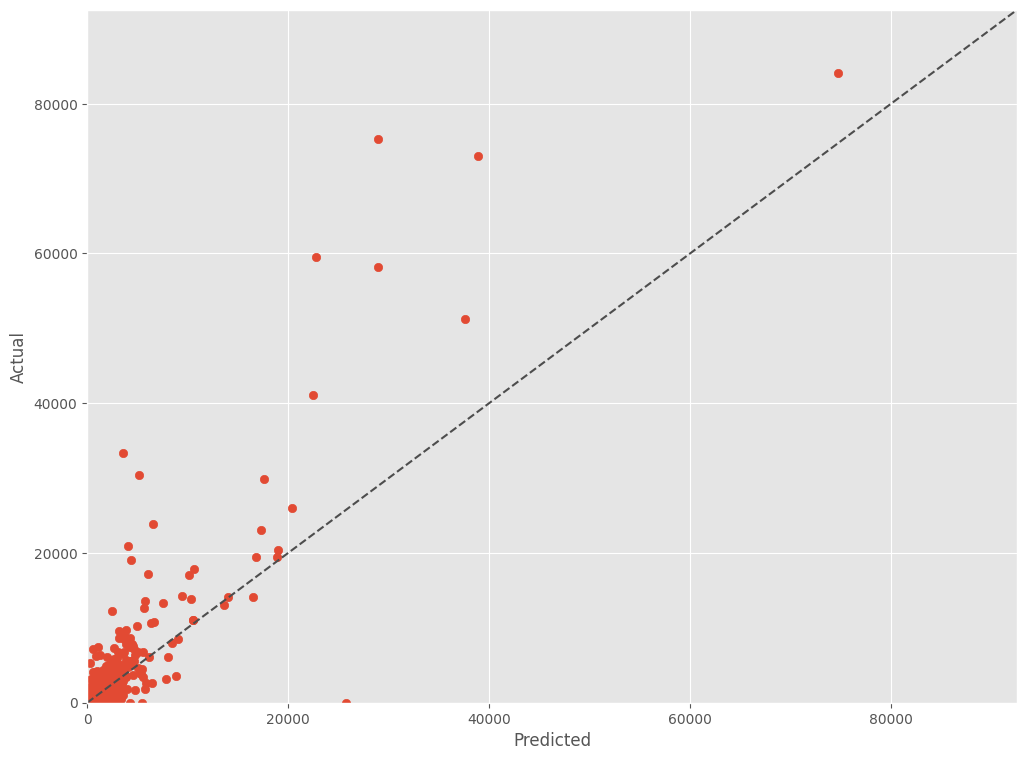

RMSE:
2950.6331207412145
MAE:
1060.3030594110498
R:
0.8782437689847082


In [20]:
# では、テストデータ期間（後半半年）の実測値（actual）と予測値（predicted）を比較してみます。
# 以下、コードです。

# 実測値と予測値の代入
actual = rfm_train_test['frequency_holdout'] * rfm_train_test['monetary_value_holdout']
predicted = rfm_train_test['cltv']

# 散布図（予測Predict × 実測Actual）
xylim = max(max(predicted), max(actual))*1.1
plt.scatter(predicted, actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlim(0, xylim)
plt.ylim(0, xylim)
plt.plot([0, xylim], [0, xylim], ls="--", c=".3")
plt.show()

# 予測精度
print('RMSE:')
print(mean((actual - predicted)**2)**.5)

print('MAE:')
print(mean_absolute_error(actual, predicted))

print('R:')
print(np.corrcoef(actual, predicted)[0,1])

# 前半半年（学習データ期間）よりも後半半年（テストデータ期間）の方が、購買回数の実測値（actual）が大きい影響からか、
# CLTV（顧客生涯価値）の予測値も、前半半年（学習データ期間）よりも後半半年（テストデータ期間）の方が大きくなっています。

# この差分は、季節性が影響しているのかもしれません。
# 先程の言いましたが、本来であれば、半年ではなく「学習データ期間：1年間」「テストデータ期間：1年間」とした方がいいでしょう。

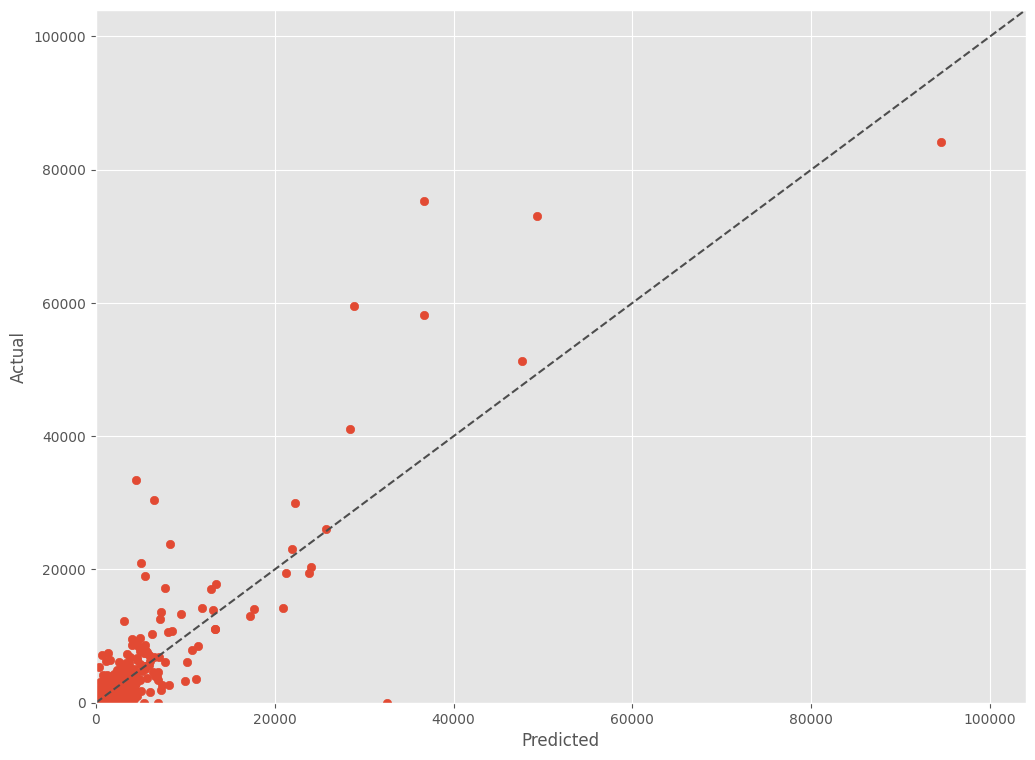

RMSE:
2647.0044752158674
MAE:
1102.4163094123842
R:
0.8782437689847079


In [21]:
# 購買回数モデル（BG/NBDモデル）のときと同様に、補正係数を使い予測値を補正しプロットします。
# 以下、コードです。

# 実測値と補正済み予測値の代入
actual = rfm_train_test['frequency_holdout'] * rfm_train_test['monetary_value_holdout']
predicted = correction_coef * predicted

# 散布図（予測Predict×実測Actual）
xylim = max(max(predicted), max(actual))*1.1
plt.scatter(predicted, actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlim(0,xylim)
plt.ylim(0,xylim)
plt.plot([0, xylim], [0,xylim], ls="--", c=".3")
plt.show()

# 予測精度
print('RMSE:')
print(mean((actual - predicted)**2)**.5)

print('MAE:')
print(mean_absolute_error(actual, predicted))

print('R:')
print(np.corrcoef(actual, predicted)[0,1])

# 運用時に使うモデルを構築しCLTVを予測

ここまでは、CLTV（顧客生涯価値）予測モデルの検討です。

この結果が満足するものと判断したら、次に実施すべきは実際の運用時に使うモデルの構築です。

実際の運用時に使うモデルは、データを分割せず全データ期間を使い学習し求めます。

要するに、1年間のデータでCLTV（顧客生涯価値）予測モデルを構築し、次年1年間（time=12）の顧客価値を予測します。

以下、コードです。

In [22]:
# BG/NBDモデルの学習
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(
    rfm['frequency'],
    rfm['recency'],
    rfm['T']
)

# GGモデルの学習（学習期間）
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(
    rfm['frequency'],
    rfm['monetary_value']
)

# CLTV予測
cltv = ggf.customer_lifetime_value(
    bgf, # 未来のトランザクション数を予測するために使用するモデル（通常はBG/NBDモデル）
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=12, # 予測期間を指定（ここでは12ヶ月）
    freq='D', # トランザクションデータの頻度を指定（ここでは日次データ）
    discount_rate=0.01
)

# ggf.customer_lifetime_value(): Gamma-Gammaモデルを使用して、顧客生涯価値（CLTV）を予測します。
# bgf: 未来のトランザクション数を予測するために使用されるモデル。通常はBG/NBDモデル（購買頻度の予測）が使用されます。
# rfm['frequency']: 顧客の購買頻度（Frequency）のデータ。
# rfm['recency']: 顧客の最終購買からの経過日数（Recency）のデータ。
# rfm['T']: 顧客が観察される期間の長さ（トレーニングデータ期間）のデータ。
# rfm['monetary_value']: 顧客の平均購買金額（Monetary Value）のデータ。
# time = 12: 予測期間を指定します。ここでは12ヶ月に設定されています。
# freq = 'D': トランザクションデータの頻度を指定します。ここでは日次データを示す 'D' が使用されています。
# discount_rate=0.01: 割引率を指定します。これは将来のキャッシュフローを現在価値に変換するために使用されます。デフォルトでは0.01（1%）に設定されています。

# データセットにCLTV追加
rfm['cltv'] = cltv

In [23]:
# 次年1年間の価値の高い順に顧客を出力します（Top10）。
# 以下、コードです。

# CLTV Top10
rfm.sort_values('cltv', ascending=False).head(10)

,frequency,recency,T,monetary_value,cltv
CustomerID,,,,,
14646.0,42.0,338.0,345.0,6390.643810,201343.214225
18102.0,23.0,356.0,358.0,9663.103913,164727.998099
17450.0,25.0,357.0,358.0,7638.382000,141214.385602
12415.0,15.0,313.0,328.0,8322.195333,100599.088109
14911.0,126.0,364.0,364.0,1081.672698,97092.930371
14096.0,15.0,90.0,92.0,3523.196667,91763.646485
14156.0,42.0,362.0,362.0,2787.081667,84890.791642
17511.0,25.0,357.0,364.0,3274.292800,59962.491210
16029.0,38.0,335.0,364.0,2034.808421,55907.073552


In [24]:
# CLTV（顧客生涯価値）と言いながら「1年間だけ？？？」と思われた方もいることでしょう。
# 長期間にするためには、幾つか方法があります。
# 1つは顧客ごとに年間購買金額と離反確率を予測し、CLTV（顧客生涯価値）を見積もる（CLTV = 年間購買金額÷離反率）という方法です。
# 一様、BG/NBDモデルから生存確率を求めることができますので、離反確率（ = 1 – 生存確率 ）も計算できます。
# 以下、コードです。

# 生存確率
alive = bgf.conditional_probability_alive(
    rfm['frequency'],
    rfm['recency'],
    rfm['T']
)

# 離反確率（データフレームで出力）
pd.DataFrame(1-alive)

,0
0,0.003621
1,0.009433
2,0.003224
3,0.009149
4,0.007842
...,...
2693,0.066523
2694,0.005750
2695,0.112118
2696,0.000855


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

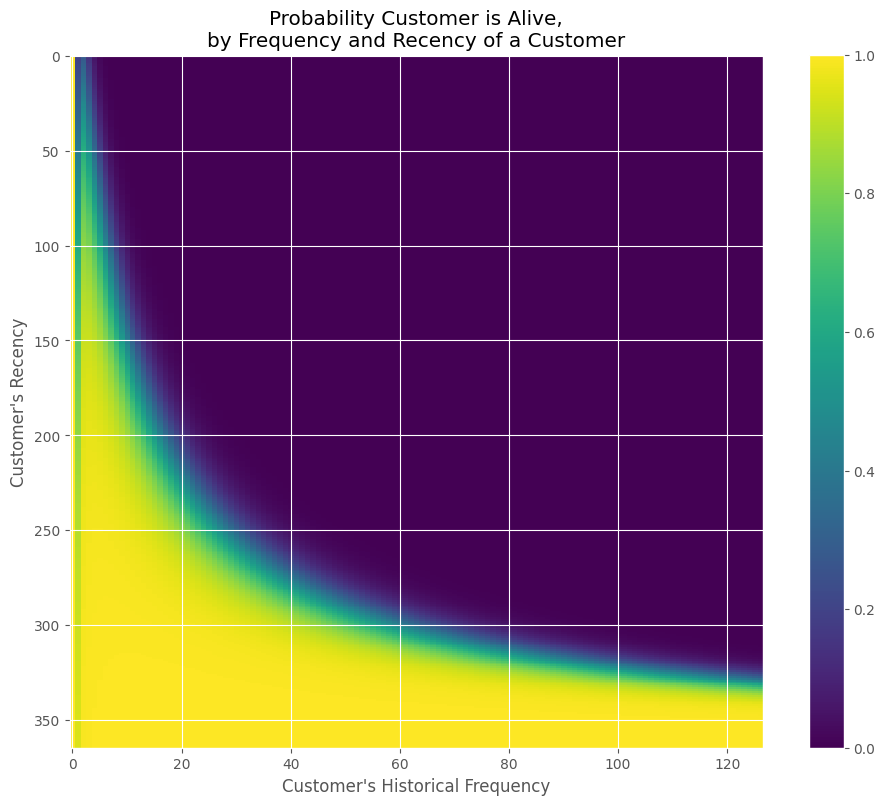

In [25]:
# 面白いことに、パッケージLifetimesに、生存確率（alive）をグラフ化する関数があります。
# 以下、コードです。

# 提供されたコードは、lifetimes パッケージからの plot_probability_alive_matrix 関数を使用して、
# BG/NBDモデルに基づく生存確率行列（Probability Alive Matrix）をプロットしています。これは、顧客の生存確率を視覚化するためのグラフです。

from lifetimes.plotting import plot_probability_alive_matrix
# lifetimes パッケージから plot_probability_alive_matrix 関数を読み込みます。このパッケージは、顧客の生存分析や顧客価値予測に使用されます。

plot_probability_alive_matrix(bgf)
# BG/NBDモデル (bgf) に基づく生存確率行列をプロットします。
# 生存確率行列は、異なる購買頻度 (frequency) と最終購買からの経過日数 (recency) の組み合わせに対する生存確率を示す行列です。

# プロットの理解:
# プロットされた行列では、横軸が購買頻度 (frequency)、縦軸が最終購買からの経過日数 (recency) となっています。
# 各セルは、対応する購買頻度と最終購買からの経過日数の組み合わせに対する生存確率を色で表しています。
# 生存確率は、特定の期間内に次回の購買が行われる確率を示しています。

# このプロットは、購買履歴から導出されたモデルに基づいて、顧客の将来の行動の傾向を視覚化するために使用されます。
# 生存確率が高い領域は、顧客が再び購買する可能性が高いことを示しています。

In [26]:
# もっとシンプルに長期間のCLTV（顧客生涯価値）を見積もる方法があります。
# 予測期間（time）を長くすればいいのです。

# 先程の予測期間（time）は1年間（12ヶ月間）でした。それを10年間（120ヶ月間）や100年間（1200ヶ月間）などと、長くすればいいのです。
# 実際に見積もってみます。以下コードです。

# BG/NBDモデルの学習
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(
    rfm['frequency'],
    rfm['recency'],
    rfm['T']
)

# GGモデルの学習（学習期間）
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(
    rfm['frequency'],
    rfm['monetary_value']
)

# CLTV12予測（1年間）
cltv = ggf.customer_lifetime_value(
    bgf,
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=12, # months
    freq='D',
    discount_rate=0.01
)

# データセットにCLTV12追加
rfm['cltv12'] = cltv

# CLTV120予測（10年間）
cltv = ggf.customer_lifetime_value(
    bgf,
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=120, # months
    freq='D',
    discount_rate=0.01
)

# データセットにCLTV120追加
rfm['cltv120'] = cltv

# CLTV1200予測（100年間）
cltv = ggf.customer_lifetime_value(
    bgf,
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=1200, # months
    freq='D',
    discount_rate=0.01
)

# データセットにCLTV120追加
rfm['cltv1200'] = cltv

# CLTV Top10
rfm.sort_values('cltv12', ascending=False).head(10)

# Top1のCustomerID:14646のCLTV（顧客生涯価値）を見比べてみます。小数点を丸めています。

# CLTV12（1年間）： 201,343
# CLTV120（10年間）：1,235,237
# CLTV1200（100年間）：1,764,974

# 流石に、CLTV12（1年間）とCLTV120（10年間）は大きく異なりますが、
# CLTV120（10年間）とCLTV1200（100年間）の差は期間差（90年間）に比べそれほど大きくありません。

# CLTV（顧客生涯価値）を考えるビジネスを、どのくらいの先まで考えるかで決めればよいかと思います。

,frequency,recency,T,monetary_value,cltv,cltv12,cltv120,cltv1200
CustomerID,,,,,,,,
14646.0,42.0,338.0,345.0,6390.643810,201343.214225,201343.214225,1.235237e+06,1.764974e+06
18102.0,23.0,356.0,358.0,9663.103913,164727.998099,164727.998099,1.010510e+06,1.443845e+06
17450.0,25.0,357.0,358.0,7638.382000,141214.385602,141214.385602,8.662982e+05,1.237799e+06
12415.0,15.0,313.0,328.0,8322.195333,100599.088109,100599.088109,6.168203e+05,8.812514e+05
14911.0,126.0,364.0,364.0,1081.672698,97092.930371,97092.930371,5.958571e+05,8.514465e+05
14096.0,15.0,90.0,92.0,3523.196667,91763.646485,91763.646485,5.610708e+05,8.012495e+05
14156.0,42.0,362.0,362.0,2787.081667,84890.791642,84890.791642,5.208770e+05,7.442772e+05
17511.0,25.0,357.0,364.0,3274.292800,59962.491210,59962.491210,3.678658e+05,5.256253e+05
16029.0,38.0,335.0,364.0,2034.808421,55907.073552,55907.073552,3.430339e+05,4.901577e+05


#補足 & 追加項目

*CLTV（顧客生涯価値）は、取引履歴のある既存顧客に対して見積もります。*

*取引履歴のないリード（見込み顧客）や1回しか取引していない顧客のCLTV（顧客生涯価値）を見積もるときには、既存顧客のCLTV（顧客生涯価値）を見積もった後に、マッチングの技術などを使い見積もります。*

*何はともあれ、取引履歴のある既存顧客に対しCLTV（顧客生涯価値）を見積もるところから始まります。*

*ちなみに、マッチングの方法は色々ありますが、一番簡単なのは、顧客の属性情報などをもとに類似度（もしくは非類似度）を計算し、重み付け平均などで見積もる方法です。このあたりの話題は、別の機会にお話しします。*

上記の「マッチング」は、既存の顧客（取引履歴のある顧客）の顧客生涯価値（CLTV）を見積もるために、取引履歴のないリードや1回しか取引していない顧客などに対して、類似した属性や特徴を持つ既存顧客を見つけ、そのグループのCLTVを参考にして見積もる手法を指します。

具体的な手法としては、顧客の属性情報（例: 年齢、性別、地域、購買履歴など）を利用して類似度を計算し、その類似した顧客グループのCLTVを元に、新しい顧客や見込み顧客のCLTVを予測するといった方法が考えられます。

例えば、属性情報が似ているグループの既存顧客が、取引履歴から計算されたCLTVが高い傾向があれば、同じ属性を持つ新しい顧客に対しても高いCLTVを予測するといったアプローチです。

このようなマッチングを行うことで、取引履歴のない顧客や初回の取引のみの顧客に対してもCLTVを見積もる手段が提供され、マーケティング戦略やリテンション戦略の立案に役立ちます。

---

マッチングの手段にはさまざまな方法があります。以下は一般的なマッチング手法のいくつかです。

## 属性ベースのマッチング:
類似度計算: 顧客の属性情報を元に、顧客間の類似度を計算します。類似度が高い顧客同士をマッチングさせます。例えば、ユークリッド距離やコサイン類似度などが使用されます。

クラスタリング: 顧客をクラスタに分け、各クラスタ内の顧客の平均などを用いてマッチングします。

## 制御グループを用いたマッチング:

プロピンシティ・スコア: 既存顧客と似た特性を持つ新しい顧客を見つけるために、プロピンシティ・スコアを用いて傾向スコアを計算し、傾向スコアが似ている顧客同士をマッチングします。

## 機械学習ベースのマッチング:
教師あり学習: 既存顧客の属性情報をもとに、顧客生涯価値（CLTV）を予測するモデルを構築し、新しい顧客に対しても同様のモデルを適用して予測します。

類似性学習: 既存顧客の購買パターンや特性に基づいて、新しい顧客の購買行動を予測するモデルを構築します。

#重み付け平均:
既存顧客のCLTVを参考にして、新しい顧客や見込み顧客のCLTVを予測する際に、類似性に応じて重み付け平均を用いる手法です。

これらの手法は、顧客データやビジネスの特性によって適した手法が異なります。適切なマッチング手法を選択するためには、データの理解とビジネスニーズに基づいた検討が必要です。

In [27]:
# 属性ベースのマッチング:類似度計算
# 属性ベースのマッチングでの類似度計算には様々な手法がありますが、代表的な方法としてユークリッド距離やコサイン類似度があります。
# 以下に、これらの類似度計算の具体例を示します。

import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity

# 仮想のデータフレームを作成
data = {
    'CustomerID': [1, 2, 3, 4, 5],
    'Age': [25, 30, 22, 35, 28],
    'PurchaseAmount': [100, 150, 80, 200, 120],
    'VisitFrequency': [5, 3, 7, 2, 4]
}

df = pd.DataFrame(data)

# 顧客間のユークリッド距離を計算
euclidean_dist = euclidean_distances(df[['Age', 'PurchaseAmount', 'VisitFrequency']])
euclidean_similarity = 1 / (1 + euclidean_dist)

# 顧客間のコサイン類似度を計算
cosine_sim = cosine_similarity(df[['Age', 'PurchaseAmount', 'VisitFrequency']])

# 結果の表示
print("Euclidean Similarity:")
display(pd.DataFrame(euclidean_similarity, columns=df['CustomerID'], index=df['CustomerID']))

print("\nCosine Similarity:")
display(pd.DataFrame(cosine_sim, columns=df['CustomerID'], index=df['CustomerID']))

# この例では、顧客の属性として年齢（Age）、購買金額（PurchaseAmount）、来店頻度（VisitFrequency）が考えられます。
# ユークリッド距離やコサイン類似度を計算して、顧客間の類似度を表す行列を作成しています。
# ユークリッド距離は距離が短いほど類似度が高くなり、コサイン類似度は1に近いほど類似度が高いです。

# この類似度行列を使用して、マッチングや推薦などのタスクを行うことができます。
# なお、実際の業務においては、適切な属性の選択や正規化などが重要なポイントとなります。

Euclidean Similarity:


CustomerID,1,2,3,4,5
CustomerID,,,,,
1,1.000000,0.019497,0.046899,0.009848,0.047062
2,0.019497,1.000000,0.013973,0.019509,0.032172
3,0.046899,0.013973,1.000000,0.008210,0.024062
4,0.009848,0.019509,0.008210,1.000000,0.012296
5,0.047062,0.032172,0.024062,0.012296,1.000000



Cosine Similarity:


CustomerID,1,2,3,4,5
CustomerID,,,,,
1,1.000000,0.998453,0.999091,0.996686,0.999748
2,0.998453,1.000000,0.995409,0.999661,0.999411
3,0.999091,0.995409,1.000000,0.992735,0.997900
4,0.996686,0.999661,0.992735,1.000000,0.998179
5,0.999748,0.999411,0.997900,0.998179,1.000000


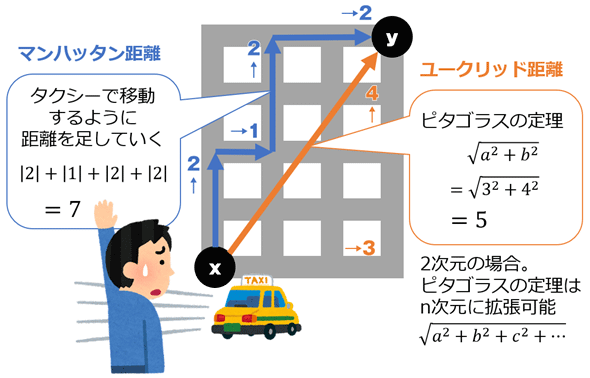

In [28]:
# ユークリッド距離は、座標空間において2点間の直線距離を計測する方法です。
# 数学的には、2点 P(x1,y1)とQ(x1,y1)の間のd は以下のように表されます。

# ​d = √(x2-x1)**2 + (y2-y1)**

# この距離は、2点を結ぶ直線の長さを示しています。ユークリッド距離が短いほど、2点は空間的に近いと言えます。
# ユークリッド距離は3次元以上の多次元空間においても同様に拡張され、n次元空間の2点PとQの間の距離は以下のように一般化されます。

# ​d = √(x2-x1)**2 + (y2-y1)**  + ... + (z2-z1)**

# PythonのサイエンスライブラリであるNumPyを使用して、ユークリッド距離を計算する具体例を以下に示します。

import numpy as np

# 2点の座標を定義
point1 = np.array([1, 2])
point2 = np.array([4, 6])

# ユークリッド距離を計算
distance = np.linalg.norm(point2 - point1)

print("ユークリッド距離:", distance)
# この例では、点 (1,2)と (4,6)の間のユークリッド距離が計算されます。
# NumPyのnp.linalg.norm関数は、ユークリッド距離を計算するために使用されています。

ユークリッド距離: 5.0


In [29]:
# コサイン類似度（Cosine Similarity）は、2つのベクトル間の類似度を計算する手法の一つです。
# 主に文書やテキストデータの類似性を評価する際に利用されますが、他の種類のデータにも適用可能です。
# コサイン類似度は、ベクトル同士のなす角の余弦を計算して類似度を評価します。

# 2つのベクトル A と B が与えられた場合、コサイン類似度 sim(A,B) は以下の式で表されます。

# sim(A,B)= A⋅B / ∥A∥⋅∥B∥

# ここで、A⋅B はベクトル A と B の内積を、∥A∥ および ∥B∥ はそれぞれベクトル A と B のノルム（大きさ）を表します。
# コサイン類似度は、ベクトルの向きに注目するため、スケールが異なる場合でも類似性を正確に評価できる利点があります。値の範囲は
# [−1,1] で、1に近いほど類似度が高いことを示します。0は無関係を、-1は反対を意味します。

# 以下に、Pythonを使用してコサイン類似度を計算する簡単な例を示します。

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 2つのベクトルを定義
vector_a = np.array([1, 2, 3])
vector_b = np.array([4, 5, 6])

# コサイン類似度を計算
similarity = cosine_similarity([vector_a], [vector_b])

display("コサイン類似度:", similarity[0, 0])

# この例では、ベクトル [1,2,3] と [4,5,6] の間のコサイン類似度を計算しています。
# NumPyおよびscikit-learnのcosine_similarity関数が使用されています。

'コサイン類似度:'

0.9746318461970762

In [30]:
# クラスタリングを使用してマッチングを行う一般的な手順は、次の通りです。
# データの前処理: マッチングを行うデータを適切に前処理します。これには、欠損値の処理、カテゴリカル変数のエンコーディング、標準化などが含まれます。
# 特徴ベクトルの作成: マッチングに使用する特徴ベクトル(説明変数, )を定義します。これは、類似性を評価するための基準となる特徴の集合です。
# クラスタリング: 特徴ベクトルを用いてデータをクラスタリングします。クラスタリングアルゴリズムとしては、K-means、階層的クラスタリング、DBSCANなどが一般的に使用されます。
# クラスタリング結果の解釈: クラスタリング結果を解釈し、各クラスタがどのような特徴を持っているかを理解します。これにより、異なるクラスタが異なる特性を持つグループを表すことが期待されます。
# マッチングの実行: 新しいデータポイントが与えられた場合、そのデータポイントをクラスタリングし、同じまたは類似のクラスタ内のデータポイントとマッチングします。

# 以下に、K-meansクラスタリングを使用した簡単な例を示します。
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# サンプルデータ
data = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12],
])

# K-meansクラスタリング
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(data)

# 新しいデータポイント
new_data_point = np.array([[2, 3, 4]])

# 新しいデータポイントをクラスタリング
new_cluster = kmeans.predict(new_data_point)

# クラスタリング結果の表示
display("クラスタリング結果:", clusters)
display("新しいデータポイントのクラスタ:", new_cluster[0])
# この例では、3次元のデータポイントを2つのクラスタにクラスタリングしています。
# 新しいデータポイント（2,3,4）がどのクラスタに所属するかを予測しています。

'クラスタリング結果:'

array([1, 1, 0, 0], dtype=int32)

'新しいデータポイントのクラスタ:'

1

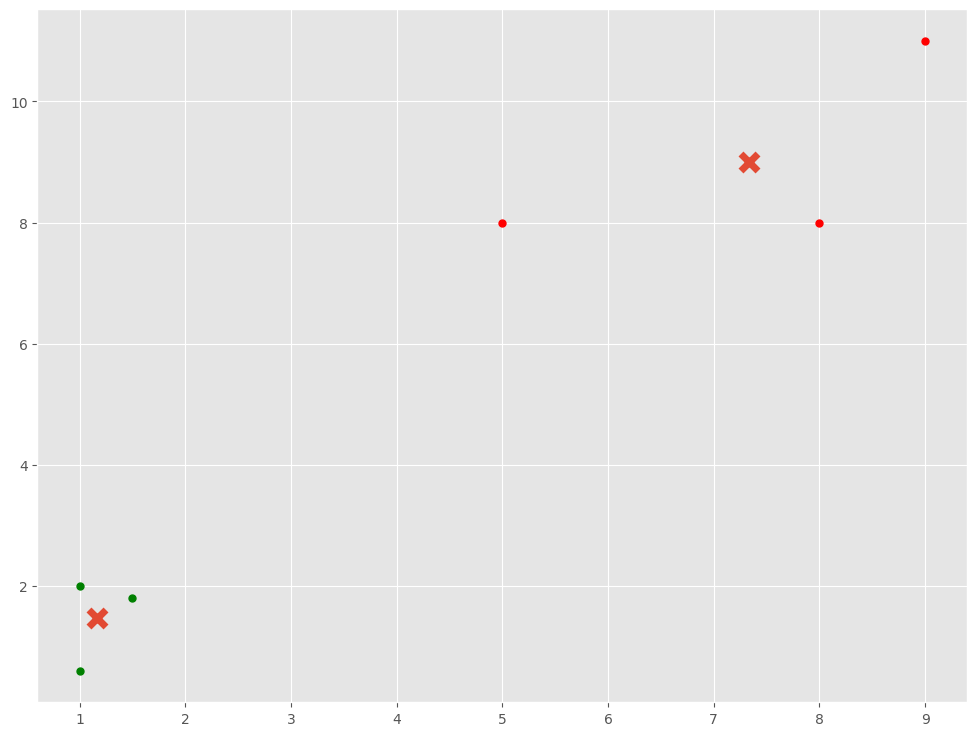

In [31]:
# それぞれのクラスタリング手法について、Pythonでの具体例を挙げて説明します。
# K-means クラスタリング

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# サンプルデータ生成
np.random.seed(0)
X = np.array([[1, 2], [5, 8], [1.5, 1.8], [8, 8], [1, 0.6], [9, 11]])

# K-means クラスタリング
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
labels = kmeans.labels_

# クラスタリング結果の表示
colors = ["g.", "r."]
for i in range(len(X)):
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize=10)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker="x", s=150, linewidths=5, zorder=10)
plt.show()

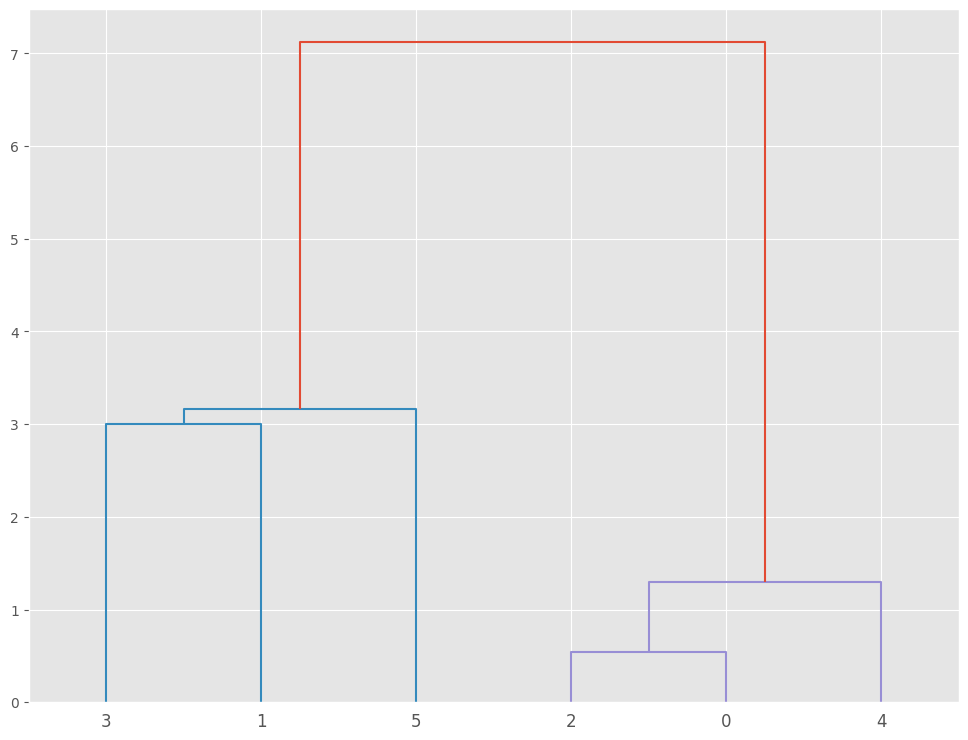

In [32]:
# 階層的クラスタリング
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# サンプルデータ生成
np.random.seed(0)
X = np.array([[1, 2], [5, 8], [1.5, 1.8], [8, 8], [1, 0.6], [9, 11]])

# 階層的クラスタリング
linked = linkage(X, 'single')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

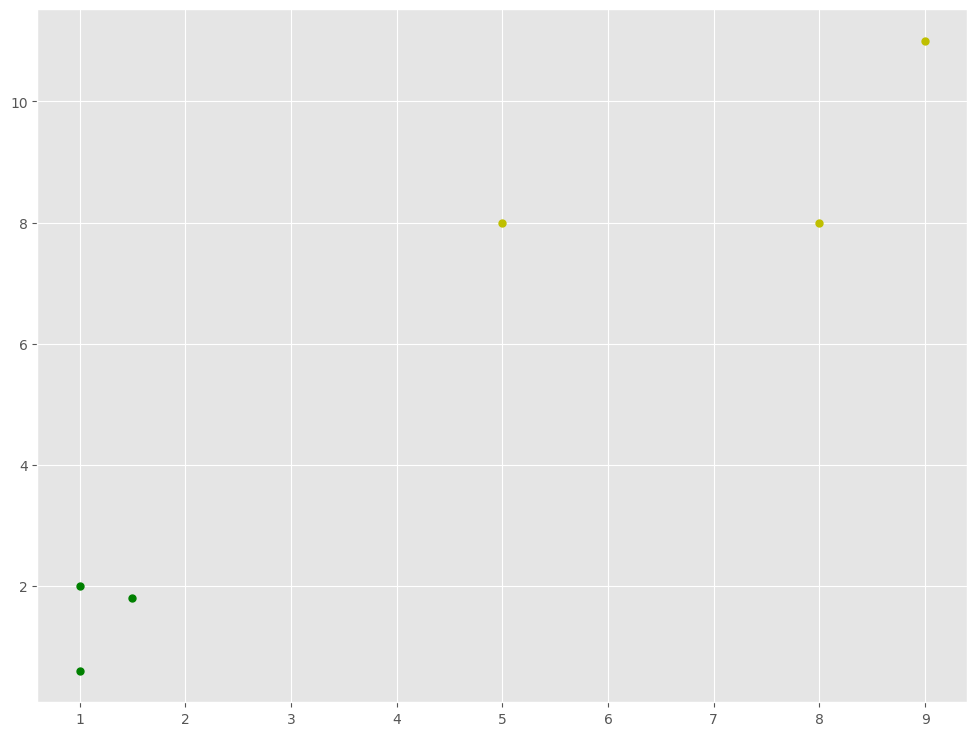

In [33]:
# DBSCAN クラスタリング
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# サンプルデータ生成
np.random.seed(0)
X = np.array([[1, 2], [5, 8], [1.5, 1.8], [8, 8], [1, 0.6], [9, 11]])

# DBSCAN クラスタリング
dbscan = DBSCAN(eps=2, min_samples=2)
dbscan.fit(X)
labels = dbscan.labels_

# クラスタリング結果の表示
colors = ["g.", "r.", "b.", "y."]
for i in range(len(X)):
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize=10)
plt.show()

# これらの例では、それぞれ異なるクラスタリング手法を使って2つのクラスタに分ける例を示しています。
# 各手法の詳細なパラメータや使用方法については、各手法のドキュメントや説明を確認してください。

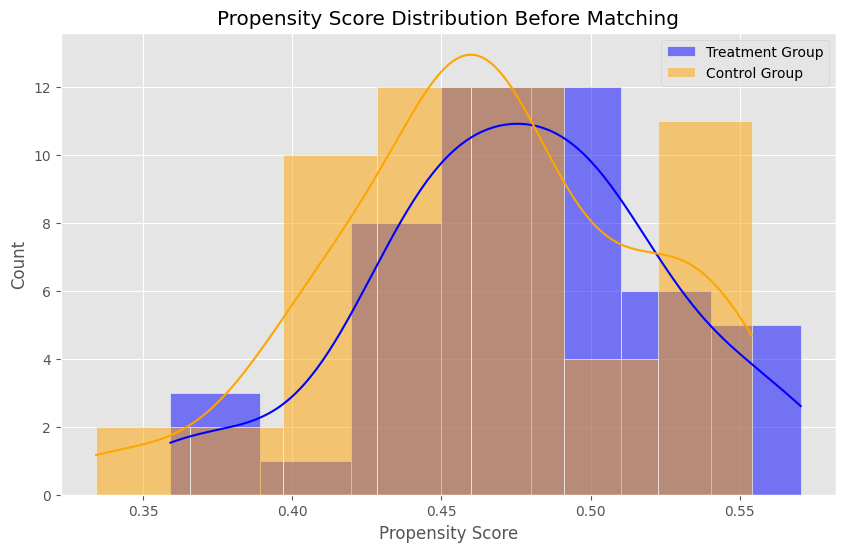

In [34]:
# プロピンシティ・スコア（Propensity Score）は、実験群と制御群の間で観察される変数（共変量）のパターンを要約した指標です。
# これは傾向スコアとも呼ばれ、実験群と制御群の類似性を表すもので、マッチング手法で使用されます。
# 以下に、プロピンシティ・スコアを計算する具体的な例を示します。この例では、傾向スコアを計算するためにロジスティック回帰モデルを使用します。
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# サンプルデータ生成
np.random.seed(42)
data = pd.DataFrame({
    'Treatment': np.random.choice([0, 1], size=100, p=[0.5, 0.5]),
    'Covariate1': np.random.normal(0, 1, 100),
    'Covariate2': np.random.normal(0, 1, 100),
})

# ロジスティック回帰モデルでプロピンシティ・スコア計算
X = data[['Covariate1', 'Covariate2']]
y = data['Treatment']

model = LogisticRegression(random_state=42)
model.fit(X, y)
propensity_scores = model.predict_proba(X)[:, 1]

# データにプロピンシティ・スコアを追加
data['PropensityScore'] = propensity_scores

# マッチング前の実験群と制御群のプロピンシティ・スコア分布を確認
treatment_group = data[data['Treatment'] == 1]
control_group = data[data['Treatment'] == 0]

# プロピンシティ・スコアの分布を比較
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(treatment_group['PropensityScore'], kde=True, label='Treatment Group', color='blue')
sns.histplot(control_group['PropensityScore'], kde=True, label='Control Group', color='orange')
plt.title('Propensity Score Distribution Before Matching')
plt.xlabel('Propensity Score')
plt.legend()
plt.show()

# この例では、Covariate1とCovariate2を共変量として、Treatmentを目的変数としたロジスティック回帰モデルを構築し、そのモデルに基づいてプロピンシティ・スコアを計算しています。
# そして、計算されたプロピンシティ・スコアを用いて、実験群と制御群の分布を比較しています。

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

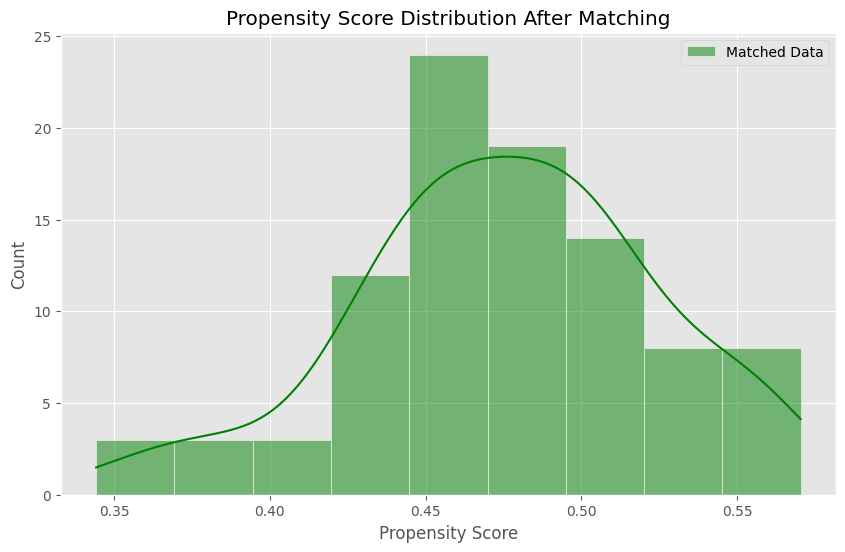

In [35]:
# プロピンシティ・スコアを計算し、そのスコアを用いてマッチングを行う手順を示します。この例では、sklearnライブラリを使用しています。
from sklearn.neighbors import NearestNeighbors

# マッチング前のデータ
data_before_matching = data.copy()

# プロピンシティ・スコアを用いてマッチング
def match_treatment_and_control(treatment_group, control_group, n_neighbors=1):
    # Nearest Neighborsを使用してマッチング
    nn_treatment = NearestNeighbors(n_neighbors=n_neighbors)
    nn_control = NearestNeighbors(n_neighbors=n_neighbors)

    # マッチング前の実験群と制御群のデータをXとyに分割
    X_treatment = treatment_group[['PropensityScore']]
    X_control = control_group[['PropensityScore']]

    # Nearest Neighborsの学習
    nn_treatment.fit(X_treatment)
    nn_control.fit(X_control)

    # マッチングするデータを格納するデータフレーム
    matched_data = pd.DataFrame(columns=data.columns)

    for idx_treatment, row_treatment in treatment_group.iterrows():
        # マッチングするためのデータを選択
        treatment_score = row_treatment['PropensityScore']
        treatment_score = np.array([[treatment_score]])

        # Nearest Neighborsを使用して最も近い制御群のデータを選択
        _, idx_matched = nn_control.kneighbors(treatment_score)
        row_matched = control_group.iloc[idx_matched[0][0]]

        # マッチングされたデータを結合
        matched_data = matched_data.append(row_treatment)
        matched_data = matched_data.append(row_matched)

    return matched_data

# マッチング前の実験群と制御群を分割
treatment_group_before = data_before_matching[data_before_matching['Treatment'] == 1]
control_group_before = data_before_matching[data_before_matching['Treatment'] == 0]

# マッチングを実行
matched_data = match_treatment_and_control(treatment_group_before, control_group_before)

# マッチング後のデータを可視化
plt.figure(figsize=(10, 6))
sns.histplot(matched_data['PropensityScore'], kde=True, label='Matched Data', color='green')
plt.title('Propensity Score Distribution After Matching')
plt.xlabel('Propensity Score')
plt.legend()
plt.show()

# この例では、NearestNeighborsを使用してプロピンシティ・スコアに基づいて1対1で最も近いデータを見つけ、実験群と制御群をマッチングしています。
# 最終的なmatched_dataには、マッチングされた実験群と制御群のデータが含まれています。

In [36]:
# 機械学習ベースのマッチングの教師あり学習を実装する際には、一般的には以下の手順が含まれます。
# 以下に、Pythonを使用した具体的な例を示します。この例では、簡単なテキストベースのマッチング問題を考えます。

# データの収集と前処理:
# まず、学習データを収集し、それを機械学習アルゴリズムに適した形に前処理します。以下は、仮想のデータセットの例です。
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# 仮想のデータセットを生成
data = {'文書': ['Pythonは素晴らしい言語です', '機械学習は興味深い', 'プログラミングが好きです', 'データサイエンスは未来を形作る'],
        'カテゴリ': ['プログラミング', '機械学習', 'プログラミング', 'データサイエンス']}
df = pd.DataFrame(data)

# 訓練データとテストデータに分割
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# テキストをベクトル化するためのCountVectorizerを使用
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['文書'])
X_test = vectorizer.transform(test_data['文書'])

# カテゴリを数値に変換
y_train = train_data['カテゴリ']
y_test = test_data['カテゴリ']

# モデルの選択とトレーニング:
# ここでは、ナイーブベイズ分類器を使用しますが、実際の問題に応じて他のアルゴリズムを選択できます。
# ナイーブベイズ分類器のインスタンス化とトレーニング
model = MultinomialNB()
model.fit(X_train, y_train)

# 予測と評価:
# モデルを使用して新しいデータに対する予測を行い、性能を評価します。
# テストデータで予測
y_pred = model.predict(X_test)

# モデルの性能評価
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# この例では、テキストの内容に基づいてカテゴリを予測するシンプルなマッチング問題を解決しています。
# 実際のアプリケーションでは、データの特性によってはより複雑なモデルやデータの前処理が必要となるかもしれません。

Accuracy: 0.0


In [37]:
# 類似性学習を用いた機械学習ベースのマッチングの具体的な例として、テキストデータの類似性を評価するケースを考えてみましょう。
# この例では、テキストの内容をベクトル化し、類似性を計算する方法を示します。以下に、Pythonを使用した例を示します。

# データの収集と前処理:
# まず、テキストデータを収集し、前処理を行います。次に、テキストデータをベクトル化します。
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 仮想のデータセットを生成
documents = [
    "Pythonは素晴らしい言語です",
    "機械学習は興味深い",
    "プログラミングが好きです",
    "データサイエンスは未来を形作る"
]

# テキストをTF-IDFベクトルに変換
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

# 類似性の計算:
# テキストデータがベクトル化されたら、cosine similarityを使用して文書間の類似性を計算できます。
# 文書間のcosine similarityを計算
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 例として、文書0と他の文書との類似性を表示
for i, score in enumerate(similarity_matrix[0]):
    print(f"文書0と文書{i}の類似性: {score}")

# この例では、TF-IDF（Term Frequency-Inverse Document Frequency）を使用して文書をベクトル化し、cosine similarityを計算しています。
# cosine similarityは、0から1の範囲で文書の類似性を示します。1に近いほど類似していると言えます。

# 実際のアプリケーションでは、データの特性によっては異なるベクトル化手法や類似性計算手法が適していることがあります。
# また、大規模なデータセットや高次元のデータでは、計算効率やメモリの使用に注意する必要があります。

文書0と文書0の類似性: 1.0
文書0と文書1の類似性: 0.0
文書0と文書2の類似性: 0.0
文書0と文書3の類似性: 0.0


In [38]:
# マッチングにおいて、異なる要素（例: 特徴）に対して重み付けを行い、それらの重みつき平均を計算することは一般的です。
# この重み付け平均を使えば、異なる要素が異なる影響を持つ場合に、それを考慮してマッチングを行うことができます。
# 以下に、Pythonを使用した具体的な例を示します。

# 例として、異なる特徴を持つ2つの候補者があり、それぞれの特徴に重みをつけて総合的なスコアを計算するとします。
# 2人の候補者の特徴
candidate1 = {'経験年数': 5, 'スキル': 8, 'コミュニケーション能力': 7}
candidate2 = {'経験年数': 3, 'スキル': 9, 'コミュニケーション能力': 9}

# それぞれの特徴に対する重み
weights = {'経験年数': 0.3, 'スキル': 0.4, 'コミュニケーション能力': 0.3}

# 重み付け平均の計算
def weighted_average(features, weights):
    total_weighted_sum = sum(features[feature] * weights[feature] for feature in features)
    total_weight = sum(weights[feature] for feature in features)
    return total_weighted_sum / total_weight

score_candidate1 = weighted_average(candidate1, weights)
score_candidate2 = weighted_average(candidate2, weights)

print(f'候補者1のスコア: {score_candidate1}')
print(f'候補者2のスコア: {score_candidate2}')

# この例では、候補者1と候補者2のそれぞれの特徴に重みをかけ、その総和を計算しています。
# これにより、異なる特徴が異なる重要度を持つ場合に、それを考慮した総合的なスコアを得ることができます。
# 実際のアプリケーションでは、特徴や重みの設計は問題やドメインに応じて変更される可能性があります。

候補者1のスコア: 6.800000000000001
候補者2のスコア: 7.199999999999999
